# Visualize Results: Downstream Performance - "Corrupted" Experiment

This notebook should answer the questions: *Does imputation lead to better downstream performances?*

## Notebook Structure 

* Application Scenario 2 - Downstream Performance  
   * Categorical  Columns (Classification)
   * Numerical Columns (Regression)
   * Heterogenous Columns (Classification and Regression Combined)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from data_imputation_paper.experiment import read_experiment, read_csv_files
from data_imputation_paper.plotting import draw_cat_box_plot

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Settings

In [2]:
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

In [29]:
EXPERIMENT = "corrupted"

EXPERIMENT_PATH = Path(f"../data/experiments/{EXPERIMENT}/")
ALTERNATIVE_BASELINE_PATH = Path("../data/experiments/alternative_baseline_aggregated.csv")

CLF_METRIC = "Classification Tasks"
REG_METRIC = "Regression Tasks"

DOWNSTREAM_RESULT_TYPE = "downstream_performance_mean"
IMPUTE_RESULT_TYPE = "impute_performance_mean"

FIGURES_PATH = Path(f"../paper/figures/")

## Import the data

In [4]:
%%time

results = read_csv_files(read_experiment(EXPERIMENT_PATH), read_details=False)
results.head()

CPU times: user 1min 33s, sys: 4.08 s, total: 1min 38s
Wall time: 1min 48s


,experiment,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed
0,corrupted,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,MAE,0.607368,1.539765,NaN,NaN,NaN
1,corrupted,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,MSE,10.799949,33.292381,NaN,NaN,NaN
2,corrupted,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,RMSE,0.606519,2.002486,NaN,NaN,NaN
3,corrupted,AutoKerasImputer,40922,MCAR,0.30,single_all,gyro_y,impute_performance_std,MAE,0.179147,0.123156,NaN,NaN,NaN
4,corrupted,AutoKerasImputer,40922,MCAR,0.30,single_all,gyro_y,impute_performance_std,MSE,4.434295,4.787317,NaN,NaN,NaN


In [20]:
na_impute_results = results[
    (results["result_type"] == IMPUTE_RESULT_TYPE) & 
    (results["metric"].isin(["F1_macro", "MAE"]))
]
na_impute_results.drop(["baseline", "corrupted", "imputed"], axis=1, inplace=True)
na_impute_results = na_impute_results[na_impute_results.isna().any(axis=1)]
na_impute_results.shape

(0, 11)

In [21]:
alt_base = pd.read_csv(ALTERNATIVE_BASELINE_PATH)
alt_base.columns = ["experiment", "task", "pattern", "fraction", "metric", "mean", "std"]
alt_base = alt_base[2:]

alt_base["fraction"] = pd.to_numeric(alt_base["fraction"])
alt_base["mean"] = pd.to_numeric(alt_base["mean"])
alt_base["std"] = pd.to_numeric(alt_base["std"])

alt_base = alt_base[alt_base["experiment"] == "experiment_2"]  # experiment_2 == corrupted
alt_base.drop(["experiment"], axis=1, inplace=True)

alt_base = alt_base[alt_base["metric"].isin(["F1_macro", "MAE"])]
alt_base

,task,pattern,fraction,metric,mean,std
2486,6,MAR,0.01,F1_macro,0.713819,0.000722
2489,6,MAR,0.10,F1_macro,0.682978,0.003279
2492,6,MAR,0.30,F1_macro,0.614997,0.002507
2495,6,MAR,0.50,F1_macro,0.583189,0.006060
2498,6,MCAR,0.01,F1_macro,0.716568,0.004043
...,...,...,...,...,...,...
4955,42712,MCAR,0.50,MAE,110.517902,4.020476
4958,42712,MNAR,0.01,MAE,104.746531,1.704315
4961,42712,MNAR,0.10,MAE,107.093018,1.143715
4964,42712,MNAR,0.30,MAE,107.799802,1.591635


In [22]:
downstream_results = results[
    (results["result_type"] == DOWNSTREAM_RESULT_TYPE) & 
    (results["metric"].isin(["F1_macro", "MAE"]))
]

# remove experiments where imputation failed
downstream_results = downstream_results.merge(
    na_impute_results,
    how = "left",
    validate = "one_to_one",
    indicator = True,
    suffixes=("", "_imp"),
    on = ["experiment", "imputer", "task", "missing_type", "missing_fraction", "strategy", "column"]
)
downstream_results = downstream_results[downstream_results["_merge"]=="left_only"]

assert len(results["strategy"].unique()) == 1
downstream_results.drop(["experiment", "strategy", "result_type_imp", "metric_imp", "train", "test", "train_imp", "test_imp", "_merge", "corrupted", "baseline"], axis=1, inplace=True)

# join alternative baseline
downstream_results = downstream_results.merge(
    alt_base,
    right_on = ["task", "pattern", "fraction", "metric"],
    left_on = ["task", "missing_type", "missing_fraction", "metric"],
).drop(["std"], axis=1).rename({"mean": "Baseline"}, axis=1)

downstream_results = downstream_results.rename(
    {
        "imputer": "Imputation Method",
        "task": "Task",
        "missing_type": "Missing Type",
        "missing_fraction": "Missing Fraction",
        "column": "Column",
        "imputed": "Imputed"
    },
    axis = 1
)

In [23]:
rename_imputer_dict = {
    "ModeImputer": "Mean/Mode",
    "KNNImputer": "$k$-NN",
    "ForestImputer": "Random Forest",
    "AutoKerasImputer": "Discriminate DL",
    "VAEImputer": "VAE",
    "GAINImputer": "GAIN"    
}

rename_metric_dict = {
    "F1_macro": CLF_METRIC,
    "MAE": REG_METRIC
}

downstream_results = downstream_results.replace(rename_imputer_dict)
downstream_results = downstream_results.replace(rename_metric_dict)

downstream_results

,Imputation Method,Task,Missing Type,Missing Fraction,Column,result_type,metric,Baseline,Corrupted,Imputed,pattern,fraction,Baseline_2
0,Discriminate DL,40922,MCAR,0.01,gyro_y,downstream_performance_mean,Classification Tasks,0.701809,0.0,0.701783,MCAR,0.01,0.724151
1,VAE,40922,MCAR,0.01,gyro_y,downstream_performance_mean,Classification Tasks,0.701930,0.0,0.702118,MCAR,0.01,0.724151
2,Mean/Mode,40922,MCAR,0.01,gyro_y,downstream_performance_mean,Classification Tasks,0.701930,0.0,0.702123,MCAR,0.01,0.724151
3,Random Forest,40922,MCAR,0.01,gyro_y,downstream_performance_mean,Classification Tasks,0.708640,0.0,0.708875,MCAR,0.01,0.724151
4,$k$-NN,40922,MCAR,0.01,gyro_y,downstream_performance_mean,Classification Tasks,0.708640,0.0,0.708824,MCAR,0.01,0.724151
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4925,VAE,4135,MNAR,0.10,MGR_ID,downstream_performance_mean,Classification Tasks,0.677453,0.0,0.678986,MNAR,0.10,0.656096
4926,Mean/Mode,4135,MNAR,0.10,MGR_ID,downstream_performance_mean,Classification Tasks,0.664517,0.0,0.665853,MNAR,0.10,0.656096
4927,Random Forest,4135,MNAR,0.10,MGR_ID,downstream_performance_mean,Classification Tasks,0.692847,0.0,0.693750,MNAR,0.10,0.656096
4928,$k$-NN,4135,MNAR,0.10,MGR_ID,downstream_performance_mean,Classification Tasks,0.664517,0.0,0.666252,MNAR,0.10,0.656096


### Check if results are complete

In [24]:
# should have equal length
downstream_results["Imputation Method"].value_counts(dropna=False)

GAIN               828
VAE                828
Random Forest      828
$k$-NN             828
Mean/Mode          828
Discriminate DL    790
Name: Imputation Method, dtype: int64

### Robustness: check which imputers yielded `NaN`values

In [25]:
for col in downstream_results.columns:
    na_sum = downstream_results[col].isna().sum()
    if na_sum > 0:
        print("-----" * 10)        
        print(col, na_sum)
        print("-----" * 10)        
        na_idx = downstream_results[col].isna()
        print(downstream_results.loc[na_idx, "Imputation Method"].value_counts(dropna=False))
        print("\n")

## Compute Downstream Performance relative to Baseline

In [26]:
clf_row_idx = downstream_results["metric"] == CLF_METRIC
reg_row_idx = downstream_results["metric"] == REG_METRIC

In [27]:
downstream_results["Improvement"]   = (downstream_results["Imputed"] - downstream_results["Baseline"]  ) / downstream_results["Baseline"]
downstream_results.loc[reg_row_idx, "Improvement"]   = downstream_results.loc[reg_row_idx, "Improvement"]   * -1

downstream_results

,Imputation Method,Task,Missing Type,Missing Fraction,Column,result_type,metric,Baseline,Corrupted,Imputed,pattern,fraction,Baseline_2,Improvement
0,Discriminate DL,40922,MCAR,0.01,gyro_y,downstream_performance_mean,Classification Tasks,0.701809,0.0,0.701783,MCAR,0.01,0.724151,-0.000038
1,VAE,40922,MCAR,0.01,gyro_y,downstream_performance_mean,Classification Tasks,0.701930,0.0,0.702118,MCAR,0.01,0.724151,0.000267
2,Mean/Mode,40922,MCAR,0.01,gyro_y,downstream_performance_mean,Classification Tasks,0.701930,0.0,0.702123,MCAR,0.01,0.724151,0.000274
3,Random Forest,40922,MCAR,0.01,gyro_y,downstream_performance_mean,Classification Tasks,0.708640,0.0,0.708875,MCAR,0.01,0.724151,0.000332
4,$k$-NN,40922,MCAR,0.01,gyro_y,downstream_performance_mean,Classification Tasks,0.708640,0.0,0.708824,MCAR,0.01,0.724151,0.000260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4925,VAE,4135,MNAR,0.10,MGR_ID,downstream_performance_mean,Classification Tasks,0.677453,0.0,0.678986,MNAR,0.10,0.656096,0.002262
4926,Mean/Mode,4135,MNAR,0.10,MGR_ID,downstream_performance_mean,Classification Tasks,0.664517,0.0,0.665853,MNAR,0.10,0.656096,0.002011
4927,Random Forest,4135,MNAR,0.10,MGR_ID,downstream_performance_mean,Classification Tasks,0.692847,0.0,0.693750,MNAR,0.10,0.656096,0.001304
4928,$k$-NN,4135,MNAR,0.10,MGR_ID,downstream_performance_mean,Classification Tasks,0.664517,0.0,0.666252,MNAR,0.10,0.656096,0.002611


## Application Scenario 2 - Downstream Performance

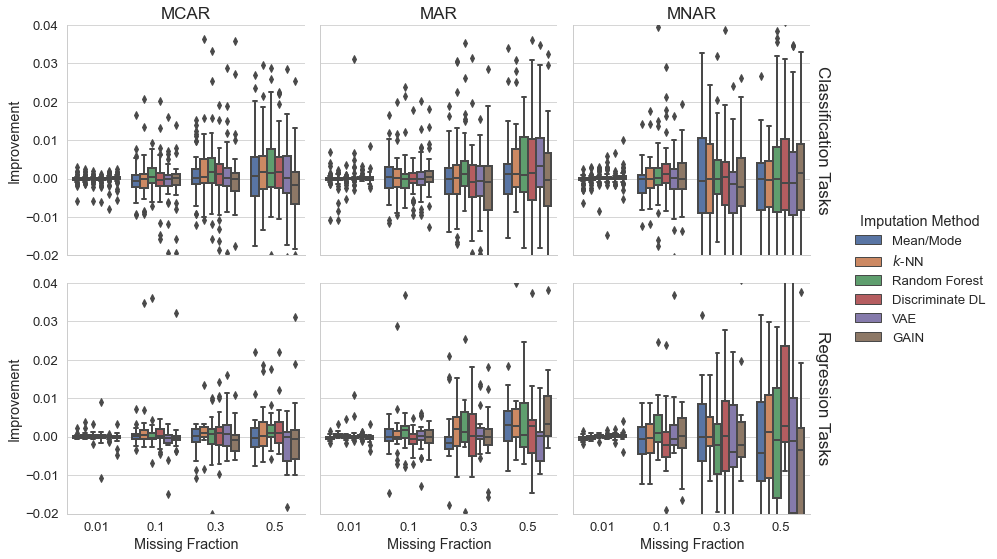

In [30]:
draw_cat_box_plot(
    downstream_results,
    "Improvement",
    (-0.02, 0.04),
    FIGURES_PATH,
    "corrupted_downstream_boxplot.eps",
    hue_order=list(rename_imputer_dict.values()),
    row_order=list(rename_metric_dict.values())
)